In [ ]:
!rm -rf *
!git clone "https://github.com/hmda77/Ensemble-Indoor-Loc"
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Test-data.csv /content/
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Training-data.csv /content/
!rm -rf /content/Ensemble-Indoor-Loc/

# Import Packages



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder , normalize

import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from matplotlib import pyplot

# Metric Functions

In [2]:

# Make the confusion matrix
def confusion_plot(y_test,y_pred,title):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix {}".format(title))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    # report['Label']=[data_classes[i]  if i<5 else " " for i,x in enumerate(report.index)]
    report=report[['f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (5,4)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    # plt.title('ROC Curve for calss {0}'.format(data_classes[pos_label]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,title):
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i],pos_label= i)
      plt.plot(fpr, tpr,lw=1)
    plt.plot([0 ,1],[0 ,1],'r')
    plt.title('ROC Curve for all classes in {}'.format(title))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # plt.legend(data_classes)
    plt.show()

#Dateset Proccesses

In [3]:
data_train = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Training-data.csv")
data_train.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Hamid\AppData\Local\Temp\ipykernel_8972\1745947030.py:1: SyntaxWarning: invalid escape sequence '\H'
  data_train = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Training-data.csv")


,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP167,AP168,AP169,AP170,AP171,AP172,Rs,Hpr,Did,Ts
0,L4-40-1,-84,-80,-71,-58,-110,-72,-71,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469870570949
1,L4-40-1,-84,-79,-71,-58,-110,-72,-71,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1470047205646
2,L4-40-1,-110,-110,-70,-56,-110,-69,-68,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469870932338
3,L4-40-1,-110,-110,-70,-53,-110,-69,-68,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1470047629440
4,L4-37-2,-84,-82,-75,-65,-110,-73,-75,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469876622694


In [4]:
data_train['Did'] = data_train['Did'].astype(str).str[1]
data_train['Did'] = pd.to_numeric(data_train['Did'])

In [8]:
data_test = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Test-data.csv")
data_test.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Hamid\AppData\Local\Temp\ipykernel_8972\2397508738.py:1: SyntaxWarning: invalid escape sequence '\H'
  data_test = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Test-data.csv")


,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP167,AP168,AP169,AP170,AP171,AP172,Rs,Hpr,Did,Ts
0,L4-33-13,-77,-58,-66,-64,-92,-66,-66,-93,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813137748
1,L4-33-13,-90,-58,-78,-56,-92,-74,-74,-87,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813179138
2,L4-33-13,-80,-64,-78,-56,-92,-74,-74,-87,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489812948443
3,L4-33-13,-72,-60,-74,-58,-93,-75,-76,-95,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489812959103
4,L4-33-13,-82,-56,-74,-56,-93,-71,-76,-89,-110,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813079167


In [9]:
data_test['Did'] = data_test['Did'].astype(str).str[1]
data_test['Did'] = pd.to_numeric(data_test['Did'])

In [10]:
#make X_train from Tr
X = normalize(data_train.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')])
y = data_train.Cid

Xt = normalize(data_test.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')])
yt = data_test.Cid

le = LabelEncoder()
le.fit(y)
le.transform(y)


X_train = X
y_train_encode =  le.transform(y)

X_test = Xt
y_test_encode = le.transform(yt)

# Random Forest, Deceision Trees, Extra Tree

## Deceision Tree

In [11]:
dt_model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
                                 random_state=0)
dt_model.fit(X_train, y_train_encode)

DecisionTreeClassifier(random_state=0)

## Random Forest

In [12]:
n_estimators = 100

In [13]:
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=None,
                                      min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train_encode)

RandomForestClassifier(random_state=42)

## Extra Trees

In [14]:
et_model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=None,
                                      min_samples_split=2, random_state=42)
et_model.fit(X_train, y_train_encode)

ExtraTreesClassifier(random_state=42)

## Compute Test Error

In [15]:
dt_model_err = 1.0 - dt_model.score(X_test, y_test_encode)
rf_model_err = 1.0 - rf_model.score(X_test, y_test_encode)
et_model_err = 1.0 - et_model.score(X_test, y_test_encode)


In [16]:
# Make predictions on the test set
y_pred = dt_model.predict(X_test)
generate_classification_report(y_test_encode, y_pred)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
374,0.000000,0.000000,0.000000,3.000000
480,0.000000,0.000000,0.000000,3.000000
492,0.000000,0.000000,0.000000,2.000000
505,0.000000,0.000000,0.000000,2.000000
509,0.000000,0.000000,0.000000,3.000000
544,0.000000,0.000000,0.000000,6.000000
548,0.000000,0.000000,0.000000,11.000000
570,0.000000,0.000000,0.000000,3.000000
584,0.000000,0.000000,0.000000,3.000000
591,0.000000,0.000000,0.000000,3.000000


In [17]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)
generate_classification_report(y_test_encode, y_pred)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
604,0.000000,0.000000,0.000000,1.000000
630,1.000000,1.000000,1.000000,24.000000
631,1.000000,1.000000,1.000000,24.000000
632,1.000000,1.000000,1.000000,24.000000
633,0.933333,0.875000,1.000000,21.000000
634,1.000000,1.000000,1.000000,24.000000
635,1.000000,1.000000,1.000000,24.000000
636,1.000000,1.000000,1.000000,27.000000
638,1.000000,1.000000,1.000000,24.000000
639,1.000000,1.000000,1.000000,24.000000


In [18]:
# Make predictions on the test set
y_pred = et_model.predict(X_test)
generate_classification_report(y_test_encode, y_pred)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
604,0.000000,0.000000,0.000000,3.000000
630,0.978723,0.958333,1.000000,23.000000
631,1.000000,1.000000,1.000000,24.000000
632,0.800000,0.666667,1.000000,16.000000
633,0.837209,0.750000,0.947368,19.000000
634,0.936170,0.916667,0.956522,23.000000
635,0.933333,0.875000,1.000000,21.000000
636,0.981818,1.000000,0.964286,28.000000
638,0.979592,1.000000,0.960000,25.000000
639,1.000000,1.000000,1.000000,24.000000


## plot the result

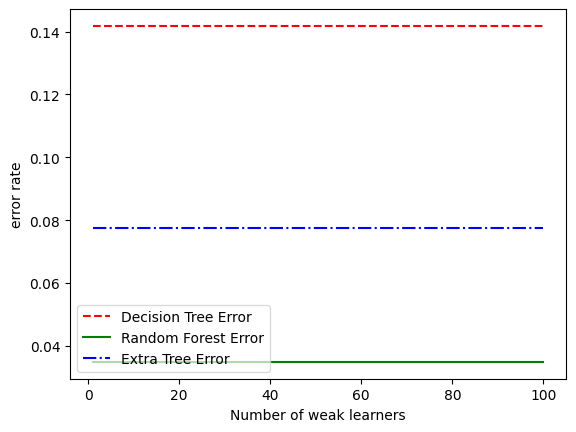

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_model_err] * 2, "r--", label="Decision Tree Error")
ax.plot([1, n_estimators], [rf_model_err] * 2, "g-", label="Random Forest Error")
ax.plot([1, n_estimators], [et_model_err] * 2, "b-.", label="Extra Tree Error")

# ax.set_ylim((0.0, 0.5))
ax.set_xlabel("Number of weak learners")
ax.set_ylabel("error rate")

leg = ax.legend(loc="lower left", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()